In [91]:
import * as nn from "../index.ts"

class Model extends nn.Module {
  seq: nn.Sequencial;
  
  constructor(input_size: number, output_size: number, hidden_dim = 10) {
    super();
    this.seq = new nn.Sequencial([
      new nn.Linear(input_size, hidden_dim),
      new nn.Sigmoid(),
      new nn.Linear(hidden_dim, hidden_dim),
      new nn.Sigmoid(),
      new nn.Linear(hidden_dim, hidden_dim),
      new nn.Sigmoid(),
      new nn.Linear(hidden_dim, output_size)
    ])
    this.register_parameters([this.seq]);
  }

  override forward(x: nn.Tensor): nn.Tensor {
    return this.seq.$(x);
  }
}


In [92]:
function create_data(start: number, end: number, num_points: number): { x: nn.Tensor, y: nn.Tensor }[] {
  const data = [];
  for (let i = 0; i < num_points; i++) {
    let x_val = start + (end - start) * i / (num_points - 1);
    let noise = (Math.random() - 0.5) * 0.2; // Adding some noise to Y
    const x = nn.Tensor.fromArray([x_val], [1, 1], false); // Input data shouldn't require gradients
    const y = new nn.Tensor([Math.cos(x.data[0]) ], [1, 1]);
    data.push({ x: x, y: y });
  }
  return data;
}


const data = create_data(-10, 10, 50);
data[0].x.data

Float32Array(1) [ -10 ]

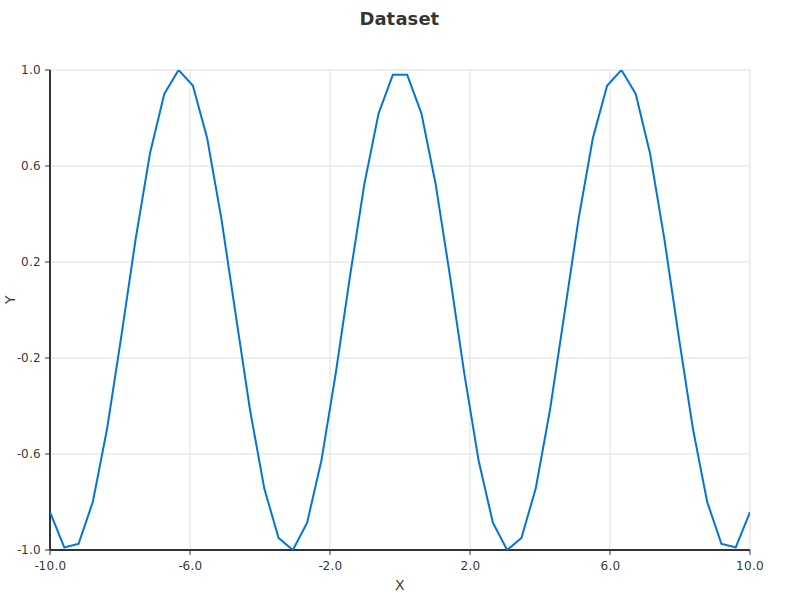

In [93]:
import { Replot } from "../plot.ts";

let dataplt = new Replot({
  width: 800,
  height: 600,
  title: "Dataset",
  xLabel: "X",
  yLabel: "Y",
  showGrid: true
});

dataplt.addPlot("line", data.map((v) => ({ x: v.x.item(), y: v.y.item() })))
Deno.jupyter.svg`${dataplt.plot()}`

In [94]:
const device = "cpu";
const model = new Model(1, 1, 1000);
await model.to(device);
const optimizer = new nn.SGD(model.parameters, 0.01);
const criterion = nn.MSELoss()

In [95]:
model.parameters_count

2005001

In [96]:

console.log("Training started...on ", device);
let total_losses: number[] = [];
for (let i = 0; i < 1; i++) {
  let total_loss = nn.Tensor.zeros([1, 1], false, device);
  for (const { x, y } of data) {
    const start = performance.now();
    await x.to(device)
    await y.to(device)
    const output = model.$(x);
    const loss = criterion(output, y);
    total_loss = nn.add(total_loss, loss) as nn.Tensor;
    const end = performance.now();
    console.log(`Forward Time taken: ${end - start} milliseconds`);
    loss.backward();
    optimizer.step();
    // epoch_loss.push(los_val);
    const end2 = performance.now();
    console.log(`Backward Time taken: ${end2 - end} milliseconds`);
    optimizer.zero_grad();
  }
  let los_val: number
  if (total_loss.device === "webgpu") {
    los_val = (await nn.WebGPU.readTensorData(total_loss))[0]
  } else {
    los_val = total_loss.data[0]
  }
  console.log(`Epoch loss: ${i}/${10}`, los_val / data.length);
  total_losses.push(los_val)
}
console.log("Total loss:", total_losses.reduce((a, b) => a + b, 0));


Training started...on  cpu


Forward Time taken: 73.89295799995307 milliseconds
Backward Time taken: 37.35275000007823 milliseconds
Forward Time taken: 11.913249999983236 milliseconds
Backward Time taken: 26.886834000004455 milliseconds
Forward Time taken: 11.859375 milliseconds
Backward Time taken: 27.505083000054583 milliseconds
Forward Time taken: 14.593166999984533 milliseconds
Backward Time taken: 30.761375000001863 milliseconds
Forward Time taken: 11.720457999967039 milliseconds
Backward Time taken: 33.382042000070214 milliseconds
Forward Time taken: 12.782083000056446 milliseconds
Backward Time taken: 29.257374999928288 milliseconds
Forward Time taken: 13.870417000027373 milliseconds
Backward Time taken: 29.654374999925494 milliseconds
Forward Time taken: 12.406624999945052 milliseconds
Backward Time taken: 55.24483300000429 milliseconds
Forward Time taken: 15.30895800003782 milliseconds
Backward Time taken: 32.8114999999525 milliseconds
Forward Time taken: 12.819625000003725 milliseconds
Backward Time take

In [97]:
const plt = new Replot({
  width: 800,
  height: 600,
  title: "Epoch Loss",
  xLabel: "Epochs",
  yLabel: "Loss",
  showGrid: true
});

plt.addPlot("line", total_losses.map((v, i) => ({ x: i, y: v })), 
  { strokeColor: "#0074d9" }, "Train Loss");

1

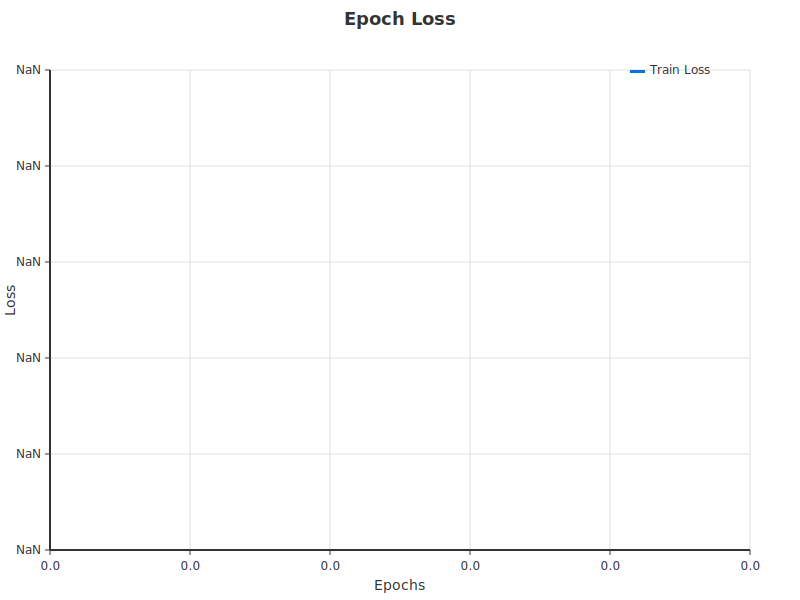

In [98]:

Deno.jupyter.svg`${plt.plot()}`

In [99]:
await model.to(device);
const pred = await Promise.all(data.map(async v => {
  await v.x.to(device);
  return {
    x: v.x.item(),
    y: device === "webgpu" ? await nn.WebGPU.readTensorData(model.$(v.x)).then(arr => {
      console.log("Predicted value array:", arr);
      return arr[0]
    }) : model.$(v.x).data[0]
  }
}));

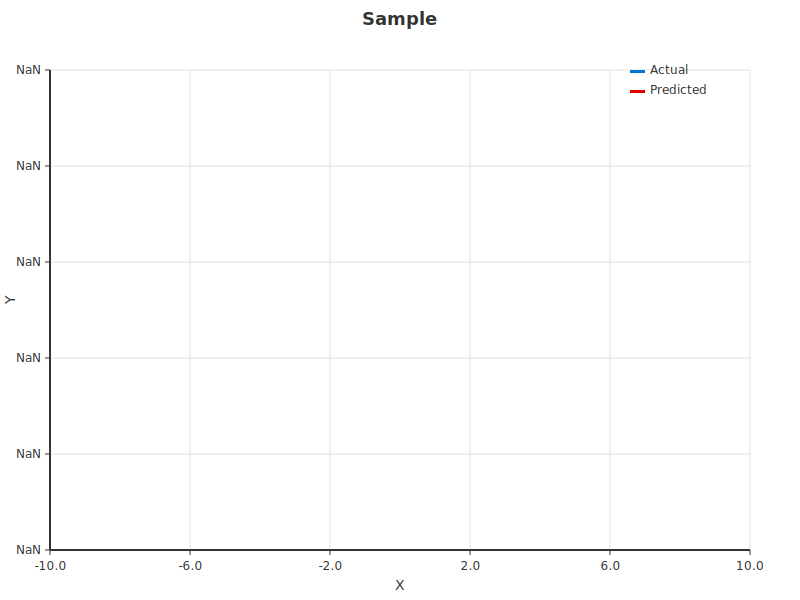

In [100]:
let out = new Replot({
  width: 800,
  height: 600,
  title: "Sample",
  xLabel: "X",
  yLabel: "Y",
  showGrid: true
});
out.addPlot("line", data.map((v) => ({ x: v.x.item(), y: v.y.item() })), { strokeColor: "#0074d9" }, "Actual")
out.addPlot("line", pred, { strokeColor: "#dF000077", }, "Predicted")
Deno.jupyter.svg`${out.plot()}`